In [1]:
! pip install pyreadr pandas matplotlib seaborn --quiet

### INSTALLING LIBRARIES

In [2]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### LOADING AND PROCESSING DATA

In [3]:
PATH = "/Users/amarnathreddykalluru/PycharmProjects/Resilience/data/portarthur_sd_df_2019.rdata"
result = pyreadr.read_r(PATH)
df = result['portarthur_sd_df_2019']
df["origin_census_block_group"] = df["origin_census_block_group"].astype(str)
df["destination_cbg"] = df["destination_cbg"].astype(str)
df["device_count"] = pd.to_numeric(df["device_count"], errors="coerce")
df["destination_device_count"] = pd.to_numeric(df["destination_device_count"], errors="coerce")
df["year"] = df["year"].astype(int)
df["uid"] = df["uid"].astype(int)
df["date"] = pd.to_datetime("2019-01-01") + pd.to_timedelta(df["uid"] - 1, unit="D")

### DISASTER DETAILS

In [4]:
DISASTER_NAME = "Tropical Storm Imelda"
disaster_start = pd.to_datetime("2019-09-17")
disaster_end = pd.to_datetime("2019-09-27")

### GROUP AND INDEGREE CALCULATION

In [6]:
def cbg_filter(df, cbg):
    return df[df['destination_cbg'] == cbg]
    
def compute_indegree_by_destination(df):
    if len(df['destination_cbg'].unique()) > 1:
        raise Exception("The Dataset has more than one CBG.")
    grouped_indegree_df = df.groupby(["destination_cbg", "date"])["destination_device_count"].sum().reset_index()
    grouped_indegree_df.rename(columns={"destination_device_count": "in_degree"}, inplace=True)
    return grouped_indegree_df

### BASELINE CALCULATION

In [7]:
def calculate_baseline(df, disaster_start, BASELINE_DAYS_TO_AVERAGE_BEFORE_DISASTER = 60):

    baseline_start = disaster_start - pd.Timedelta(days=BASELINE_DAYS_TO_AVERAGE_BEFORE_DISASTER)
    baseline_end = disaster_start - pd.Timedelta(days=1)

    baseline_df = df[
        (df["date"] >= baseline_start) &
        (df["date"] <= baseline_end)
    ]

    baseline_value = baseline_df["in_degree"].mean()
    
    return baseline_value

### SMOOTHING THE DATA

In [8]:
def smoothen_data(df, SMOOTHING_PERIOD):
    df_smoothed = df.copy()

    df_smoothed["in_degree"] = (
    df["in_degree"]
    .rolling(window=SMOOTHING_PERIOD, center=True, min_periods=1)
    .mean())

    df_smoothed["in_degree"] = (
    df_smoothed["in_degree"]
    .bfill()
    .ffill())

    return df_smoothed

### NORMALIZATION

In [9]:
def normalize_data(df):
    df_normalized = df.copy()
    min_val = df["in_degree"].min()
    max_val = df["in_degree"].max()
    df_normalized["in_degree"] = (df_normalized["in_degree"] - min_val) / (max_val - min_val)
    return df_normalized

def baseline_normalization(df, baseline_value):
    if baseline_value == 0:
        df['in_degree'] = np.nan
    else:
        df['in_degree'] = (df['in_degree'] - baseline_value) / baseline_value

    return df

### RECOVERY POINT

In [10]:
def get_recovery_point(df, disaster_end, threshold):

    post_disaster_df = df[df["date"] > disaster_end]

    if post_disaster_df.empty:
        return disaster_end

    recovered = post_disaster_df[post_disaster_df["in_degree"].abs() <= threshold]
    if not recovered.empty:
        return recovered.iloc[0]["date"]
    closest_idx = post_disaster_df["in_degree"].abs().idxmin()
    return df.loc[closest_idx, "date"]

### CALCULATE RESILIENCE

In [11]:
def compute_auc_between_dates(df, start_date, end_date):

    curve = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

    if curve.empty or len(curve) < 2:
        return 0.0

    curve = curve.set_index("date")
    curve = curve[["in_degree"]]
    curve['days'] = (curve.index - curve.index[0]).days

    area = np.trapezoid(curve["in_degree"], curve['days'])

    return area

### PLOT GRAPH

In [12]:
def plot_graph(
    df_normalized, 
    disaster_region,
    resilience_region,
    critical_events, 
    fill_region = True,
    disaster_span = True,
    critical_show = True
    ):
    
    
    mask = (df_normalized['date'] >= disaster_region[0] - pd.Timedelta(days=30))
    plot_df = df_normalized.loc[mask]
    
    max_val = abs(plot_df['in_degree'].max())
    min_val = abs(plot_df['in_degree'].min())
    y_limit = max(max_val, min_val)

    # Setup plot
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.set_ylim(-y_limit * 1.1, y_limit * 1.1)

    # Actual in_degree
    ax.plot(plot_df['date'], plot_df['in_degree'], color='black', linewidth=2, label='Normalized Mobility')

    ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.8)


    if fill_region:
        fill_mask = (plot_df['date'] >= disaster_region[0]) & (plot_df['date'] <= resilience_region[1])
        fill_df = plot_df.loc[fill_mask]

        ax.fill_between(
            fill_df['date'],
            fill_df['in_degree'],
            0,  # x-axis baseline
            where=(~fill_df['in_degree'].isna()),
            interpolate=True,
            color='orange',
            alpha=0.3,
            label='Resilience Area'
        )
    
    #disaster_span
    if disaster_span == True:
        ax.axvspan(disaster_region[0], disaster_region[1], color='red', alpha=0.2, label='Disaster Period')

    # Mark vertical events
    if critical_show == True:
    
        plot_handles, plot_labels = ax.get_legend_handles_labels()

        event_styles = {
            'disaster_start': ('darkred', 'left'),
            'disaster_end': ('orangered', 'right'),
            'recovery': ('darkgreen', 'right')
        }

        event_handles = []
        for label, date in critical_events.items():
            color, align = event_styles.get(label, ('black', 'center'))
            ax.axvline(x=date, linestyle='--', color=color, linewidth=1.5)
            ax.text(date, 1.05, "", rotation=90, ha=align, va='bottom',
                    fontsize=10, color=color, clip_on=False)
            event_handles.append(Line2D([0], [0], color=color, linestyle="--", label=label))

        all_handles = plot_handles + event_handles
        all_labels = plot_labels + list(critical_events.keys())

        ax.legend(all_handles, all_labels, loc='upper left', fontsize=10, title='Legend')

    # Plot aesthetics
    ax.set_title("(Disaster Impact & Recovery)", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Normalized Mobility", fontsize=12)
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### LOG SUMMARY

In [13]:
def log_summary(disaster_start, disaster_end, recovery_point, resilience):
    print("\nCommunity Resilience Summary")
    print("-----------------------------")
    print(f"Disaster Start Date    : {disaster_start.strftime('%Y-%m-%d')}")
    print(f"Disaster End Date      : {disaster_end.strftime('%Y-%m-%d')}")
    print(f"Recovery Point         : {recovery_point.strftime('%Y-%m-%d')}")
    print(f"Time to Recovery       : {(recovery_point - disaster_start).days} days")
    print(f"Resilience Capacity    : {resilience:.3f} (area under normalized curve)")
    

### TRY IT !!!

In [14]:
CENSUS_BLOCK_GROUP = "483610223005"
DISASTER_NAME = "Tropical Storm Imelda"
disaster_start = pd.to_datetime("2019-09-17")
disaster_end = pd.to_datetime("2019-09-27")
BASELINE_DAYS_TO_AVERAGE_BEFORE_DISASTER = 15
SMOOTHING_PERIOD = 25
THRESHOLD = 0.01


Community Resilience Summary
-----------------------------
Disaster Start Date    : 2019-09-17
Disaster End Date      : 2019-09-27
Recovery Point         : 2019-11-20
Time to Recovery       : 64 days
Resilience Capacity    : -8.015 (area under normalized curve)


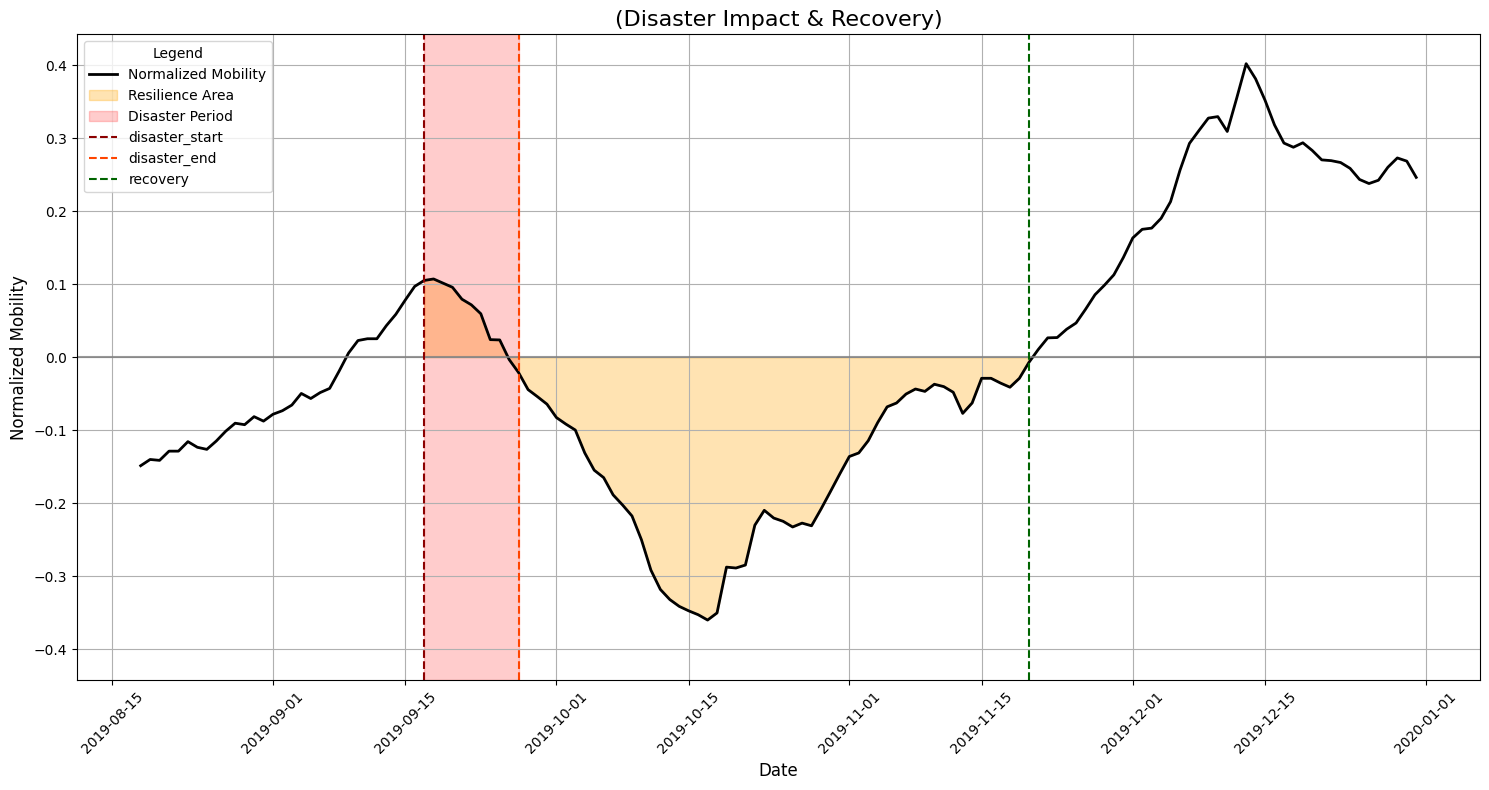

In [15]:
filtered_df = cbg_filter(df, CENSUS_BLOCK_GROUP)
indegree_df = compute_indegree_by_destination(filtered_df)
normalized_df = normalize_data(indegree_df)
smoothed_df = smoothen_data(normalized_df,SMOOTHING_PERIOD)
baseline_value = calculate_baseline(smoothed_df, disaster_start, BASELINE_DAYS_TO_AVERAGE_BEFORE_DISASTER)
bnormal_df = baseline_normalization(smoothed_df, baseline_value)
recovery_point = get_recovery_point(bnormal_df, disaster_end, THRESHOLD)
resilience = compute_auc_between_dates(bnormal_df, disaster_start, recovery_point)
log_summary(disaster_start, disaster_end, recovery_point, resilience)
plot_graph(
    bnormal_df, 
    [disaster_start, disaster_end], 
    [disaster_start, recovery_point],
    {"disaster_start": disaster_start, "disaster_end": disaster_end, "recovery": recovery_point}
    )